# PANN Generalization Test: Parametric Scenario Selection

This notebook demonstrates PANN's ability to generalize to unseen loading scenarios. You can configure which scenarios to include in training vs testing.

**Key Question**: Does PANN extrapolate better than baseline when trained on a subset of scenarios?

**Approach**: Train on diverse but limited scenarios, test on completely unseen ones (including sphere).

## Configuration: Select Training and Test Scenarios

Modify these lists to control which scenarios are used for training vs testing.

**Available scenarios**: `uniaxial_x`, `uniaxial_y`, `uniaxial_x_compression`, `uniaxial_y_compression`, `biaxial_2to1`, `equibiaxial`, `equibiaxial_compression`, `phi_45_plane`, `pure_shear`, `radial_45_45`, `simple_shear`, `sphere`

In [1]:
# ============================================================================
# CONFIGURATION: MODIFY THESE TO CHANGE TRAINING/TEST SPLIT
# ============================================================================

# Scenarios to INCLUDE in training (good intermediate set)
training_scenarios = [
    'uniaxial_x',
    'uniaxial_y',
    'uniaxial_x_compression',
    'uniaxial_y_compression',
    'biaxial_2to1',
    'pure_shear',
    'simple_shear'
]

# Scenarios to use for TESTING ONLY (never seen during training)
# These will be used to evaluate generalization capability
test_only_scenarios = [
    'sphere',                    # Most important - generic scenario
    'equibiaxial',
    'equibiaxial_compression',
    'phi_45_plane',
    'radial_45_45'
]

# Training configuration
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 32

print("Training on:", training_scenarios)
print("Testing on:", test_only_scenarios)

Training on: ['uniaxial_x', 'uniaxial_y', 'uniaxial_x_compression', 'uniaxial_y_compression', 'biaxial_2to1', 'pure_shear', 'simple_shear']
Testing on: ['sphere', 'equibiaxial', 'equibiaxial_compression', 'phi_45_plane', 'radial_45_45']


In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import load_dataset, get_component_names, prepare_data_by_groups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from src.models.base_model import build_model, train_model, evaluate_model
from src.models.pann_model import build_pann_model, train_pann_model
from src.comparison import (
    compare_predictions,
    compare_residuals,
    compare_metrics,
    generate_comparison_summary,
    plot_error_distribution_comparison
)

plt.rcParams['figure.figsize'] = (12, 4)

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Dataset and Display Scenario Distribution

In [3]:
# Load full dataset
data_path = '/Users/juanaguila/Code/neohookean-data-generator/data/consolidated_all.npz'
data = np.load(data_path)

strains = data['strains']
stresses = data['stresses']
scenario_labels = data['scenario_labels']
case_ids = data['case_ids']

# Convert E_xy to gamma_xy = 2*E_xy
strains_voigt = strains.copy()
# REMOVED: strains_voigt[:, 2] = 2 * strains[:, 2]
# Data generator already provides gamma12 = 2*E12 (Voigt notation)

print(f"Total dataset: {len(strains)} samples")
print(f"\nScenario distribution in full dataset:")
unique_scenarios, counts = np.unique(scenario_labels, return_counts=True)
for scenario, count in zip(unique_scenarios, counts):
    in_train = scenario in training_scenarios
    in_test = scenario in test_only_scenarios
    status = "TRAIN" if in_train else ("TEST" if in_test else "UNUSED")
    print(f"  {scenario:<30} {count:>5} samples  [{status}]")

Total dataset: 15925 samples

Scenario distribution in full dataset:
  biaxial_2to1                     625 samples  [TRAIN]
  equibiaxial                      625 samples  [TEST]
  equibiaxial_compression          625 samples  [TEST]
  phi_45_plane                     625 samples  [TEST]
  pure_shear                       625 samples  [TRAIN]
  radial_45_45                     625 samples  [TEST]
  simple_shear                     625 samples  [TRAIN]
  sphere                          9050 samples  [TEST]
  uniaxial_x                       625 samples  [TRAIN]
  uniaxial_x_compression           625 samples  [TRAIN]
  uniaxial_y                       625 samples  [TRAIN]
  uniaxial_y_compression           625 samples  [TRAIN]


## 2. Split Dataset by Scenario Configuration

In [4]:
# Validate configuration
all_scenarios = set(unique_scenarios)
train_set = set(training_scenarios)
test_set = set(test_only_scenarios)

# Check for overlap
overlap = train_set & test_set
if overlap:
    raise ValueError(f"Scenarios appear in both training and test: {overlap}")

# Check for invalid scenarios
invalid_train = train_set - all_scenarios
invalid_test = test_set - all_scenarios
if invalid_train:
    raise ValueError(f"Invalid training scenarios: {invalid_train}")
if invalid_test:
    raise ValueError(f"Invalid test scenarios: {invalid_test}")

print("✓ Configuration validated successfully")
print(f"  Training scenarios: {len(training_scenarios)}")
print(f"  Test-only scenarios: {len(test_only_scenarios)}")

✓ Configuration validated successfully
  Training scenarios: 7
  Test-only scenarios: 5


In [5]:
# Create masks for training and test scenarios
train_mask = np.isin(scenario_labels, training_scenarios)
test_unseen_mask = np.isin(scenario_labels, test_only_scenarios)

# Get training data
X_train_scenarios = strains_voigt[train_mask]
y_train_scenarios = stresses[train_mask]
scenarios_train = scenario_labels[train_mask]
case_ids_train = case_ids[train_mask]

# Get test data from unseen scenarios
X_test_unseen = strains_voigt[test_unseen_mask]
y_test_unseen = stresses[test_unseen_mask]
scenarios_test_unseen = scenario_labels[test_unseen_mask]

print(f"\n{'='*70}")
print(f"DATASET SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Training set: {len(X_train_scenarios):>6} samples")
print(f"Test set:     {len(X_test_unseen):>6} samples (unseen scenarios)")
print(f"{'='*70}")

print(f"\nTraining scenario breakdown:")
unique_train, counts_train = np.unique(scenarios_train, return_counts=True)
for scenario, count in zip(unique_train, counts_train):
    print(f"  {scenario:<30} {count:>5} samples")

print(f"\nTest (unseen) scenario breakdown:")
unique_test, counts_test = np.unique(scenarios_test_unseen, return_counts=True)
for scenario, count in zip(unique_test, counts_test):
    print(f"  {scenario:<30} {count:>5} samples")


DATASET SPLIT SUMMARY
Training set:   4375 samples
Test set:      11550 samples (unseen scenarios)

Training scenario breakdown:
  biaxial_2to1                     625 samples
  pure_shear                       625 samples
  simple_shear                     625 samples
  uniaxial_x                       625 samples
  uniaxial_x_compression           625 samples
  uniaxial_y                       625 samples
  uniaxial_y_compression           625 samples

Test (unseen) scenario breakdown:
  equibiaxial                      625 samples
  equibiaxial_compression          625 samples
  phi_45_plane                     625 samples
  radial_45_45                     625 samples
  sphere                          9050 samples


## 3. Further Split Training Data into Train/Val/Test

The training scenarios are split into train/val/test for model training. This creates a "seen" test set.

In [6]:
# Split training scenarios into train/val/test using case-based splitting
# This prevents data leakage by ensuring samples from the same case stay together
data_split = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=False, split_by='case'
)

# Extract the arrays from the dictionary
X_train = data_split['X_train']
X_val = data_split['X_val']
X_test_seen = data_split['X_test']
y_train = data_split['y_train']
y_val = data_split['y_val']
y_test_seen = data_split['y_test']

print(f"\nFinal split for training:")
print(f"  Train:      {len(X_train):>6} samples")
print(f"  Validation: {len(X_val):>6} samples")
print(f"  Test (seen scenarios):   {len(X_test_seen):>6} samples")
print(f"  Test (unseen scenarios): {len(X_test_unseen):>6} samples")

Splitting by case: 175 unique groups
  Train: 105 groups, 2625 samples
  Val:   35 groups, 875 samples
  Test:  35 groups, 875 samples
  ✓ No group leakage detected

Final split for training:
  Train:        2625 samples
  Validation:    875 samples
  Test (seen scenarios):      875 samples
  Test (unseen scenarios):  11550 samples


## 4. Prepare Data for Both Models

In [7]:
# Scale data for baseline model
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_seen_scaled = X_scaler.transform(X_test_seen)
X_test_unseen_scaled = X_scaler.transform(X_test_unseen)

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_seen_scaled = y_scaler.transform(y_test_seen)
y_test_unseen_scaled = y_scaler.transform(y_test_unseen)

# Package for baseline model (scaled)
data_baseline = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_seen_scaled,
    'y_train': y_train_scaled,
    'y_val': y_val_scaled,
    'y_test': y_test_seen_scaled,
    'y_test_original': y_test_seen,
    'X_scaler': X_scaler,
    'y_scaler': y_scaler
}

# Package for PANN model (unscaled)
data_pann = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test_seen,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test_seen,
    'y_test_original': y_test_seen,
    'X_scaler': None,
    'y_scaler': None
}

print("✓ Data prepared for both models")

✓ Data prepared for both models


## 5. Train Baseline Model

In [8]:
print(f"Training Baseline Model on {len(training_scenarios)} scenarios...")
print(f"  Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print()

baseline_model = build_model(input_dim=3, output_dim=3)
baseline_history = train_model(baseline_model, data_baseline, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

baseline_metrics_seen, y_pred_baseline_seen = evaluate_model(baseline_model, data_baseline)
print(f"\nBaseline R² (seen scenarios): {baseline_metrics_seen['r2']:.4f}")
print(f"Baseline params: {baseline_model.count_params():,}")

Training Baseline Model on 7 scenarios...
  Epochs: 100, Batch size: 32

Epoch 1/100


/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:17 941ms/step - loss: 2.2854 - mae: 1.1417

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0982 - mae: 0.7640 - val_loss: 0.6786 - val_mae: 0.4581 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5946 - mae: 0.5420

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.6013 - mae: 0.5581 - val_loss: 0.5266 - val_mae: 0.4042 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4041 - mae: 0.4690

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.4496 - mae: 0.4733 - val_loss: 0.3440 - val_mae: 0.3318 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3531 - mae: 0.4438

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.3656 - mae: 0.4215 - val_loss: 0.2170 - val_mae: 0.2597 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4084 - mae: 0.4616

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.3273 - mae: 0.3928 - val_loss: 0.1098 - val_mae: 0.1852 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2812 - mae: 0.3744

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.2650 - mae: 0.3506 - val_loss: 0.0461 - val_mae: 0.1192 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6751 - mae: 0.5512

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.2645 - mae: 0.3449 - val_loss: 0.0333 - val_mae: 0.0994 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3328 - mae: 0.3840

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.2275 - mae: 0.3186 - val_loss: 0.0188 - val_mae: 0.0731 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2504 - mae: 0.3264

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.2189 - mae: 0.3125 - val_loss: 0.0183 - val_mae: 0.0768 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0963 - mae: 0.2481

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.2001 - mae: 0.2975 - val_loss: 0.0179 - val_mae: 0.0755 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1742 - mae: 0.2757

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.1909 - mae: 0.2887 - val_loss: 0.0162 - val_mae: 0.0665 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1255 - mae: 0.2355

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1857 - mae: 0.2799 - val_loss: 0.0199 - val_mae: 0.0775 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1777 - mae: 0.3025

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.1719 - mae: 0.2694 - val_loss: 0.0127 - val_mae: 0.0650 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1601 - mae: 0.2822

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1687 - mae: 0.2682 - val_loss: 0.0150 - val_mae: 0.0726 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1938 - mae: 0.2722

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.1640 - mae: 0.2612 - val_loss: 0.0130 - val_mae: 0.0620 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0937 - mae: 0.2002

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1552 - mae: 0.2534 - val_loss: 0.0103 - val_mae: 0.0586 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1279 - mae: 0.2385

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.1555 - mae: 0.2541 - val_loss: 0.0111 - val_mae: 0.0593 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1007 - mae: 0.2122

58/83 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.1413 - mae: 0.2407

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1506 - mae: 0.2457 - val_loss: 0.0109 - val_mae: 0.0510 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1344 - mae: 0.2505

49/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1662 - mae: 0.2638

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1519 - mae: 0.2549 - val_loss: 0.0125 - val_mae: 0.0613 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1683 - mae: 0.3162

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.1478 - mae: 0.2463 - val_loss: 0.0132 - val_mae: 0.0599 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1019 - mae: 0.2212

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 0.1414 - mae: 0.2448 - val_loss: 0.0087 - val_mae: 0.0537 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0955 - mae: 0.2344

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.1412 - mae: 0.2462 - val_loss: 0.0075 - val_mae: 0.0480 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1091 - mae: 0.2477

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.1398 - mae: 0.2516 - val_loss: 0.0094 - val_mae: 0.0505 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1149 - mae: 0.2445

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.1426 - mae: 0.2439 - val_loss: 0.0098 - val_mae: 0.0571 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1284 - mae: 0.2162

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.1300 - mae: 0.2383 - val_loss: 0.0110 - val_mae: 0.0568 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2045 - mae: 0.2390

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.1427 - mae: 0.2466 - val_loss: 0.0088 - val_mae: 0.0548 - learning_rate: 0.0010


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1543 - mae: 0.2442

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.1347 - mae: 0.2454 - val_loss: 0.0066 - val_mae: 0.0471 - learning_rate: 0.0010


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0837 - mae: 0.1941

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.1254 - mae: 0.2341 - val_loss: 0.0066 - val_mae: 0.0508 - learning_rate: 0.0010


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1873 - mae: 0.2633

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.1204 - mae: 0.2312 - val_loss: 0.0083 - val_mae: 0.0553 - learning_rate: 0.0010


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1189 - mae: 0.2176

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.1233 - mae: 0.2285 - val_loss: 0.0069 - val_mae: 0.0498 - learning_rate: 0.0010


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0747 - mae: 0.1909

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.1311 - mae: 0.2427 - val_loss: 0.0073 - val_mae: 0.0468 - learning_rate: 0.0010


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3002 - mae: 0.3209

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 0.1332 - mae: 0.2458 - val_loss: 0.0077 - val_mae: 0.0543 - learning_rate: 0.0010


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0856 - mae: 0.2070

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.1340 - mae: 0.2442 - val_loss: 0.0102 - val_mae: 0.0533 - learning_rate: 0.0010


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1239 - mae: 0.2217

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.1463 - mae: 0.2551 - val_loss: 0.0075 - val_mae: 0.0482 - learning_rate: 0.0010


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3935 - mae: 0.3072

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 0.1319 - mae: 0.2375 - val_loss: 0.0188 - val_mae: 0.0738 - learning_rate: 0.0010


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0609 - mae: 0.1832

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.1280 - mae: 0.2384 - val_loss: 0.0058 - val_mae: 0.0497 - learning_rate: 0.0010


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0947 - mae: 0.1788

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.1287 - mae: 0.2368 - val_loss: 0.0062 - val_mae: 0.0460 - learning_rate: 0.0010


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0892 - mae: 0.2004

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1364 - mae: 0.2449 - val_loss: 0.0123 - val_mae: 0.0696 - learning_rate: 0.0010


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3010 - mae: 0.3141

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1288 - mae: 0.2429 - val_loss: 0.0106 - val_mae: 0.0611 - learning_rate: 0.0010


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0966 - mae: 0.2343

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.1300 - mae: 0.2400 - val_loss: 0.0086 - val_mae: 0.0577 - learning_rate: 0.0010


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1775 - mae: 0.2332

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1283 - mae: 0.2371 - val_loss: 0.0133 - val_mae: 0.0747 - learning_rate: 0.0010


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1795 - mae: 0.2454

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.1259 - mae: 0.2375 - val_loss: 0.0054 - val_mae: 0.0467 - learning_rate: 0.0010


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1245 - mae: 0.2613

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1280 - mae: 0.2469 - val_loss: 0.0098 - val_mae: 0.0627 - learning_rate: 0.0010


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2182 - mae: 0.2983

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1184 - mae: 0.2392 - val_loss: 0.0091 - val_mae: 0.0548 - learning_rate: 0.0010


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0687 - mae: 0.2051

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1316 - mae: 0.2393 - val_loss: 0.0103 - val_mae: 0.0634 - learning_rate: 0.0010


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0903 - mae: 0.2315

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1215 - mae: 0.2380 - val_loss: 0.0074 - val_mae: 0.0408 - learning_rate: 0.0010


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1046 - mae: 0.2703

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1190 - mae: 0.2409 - val_loss: 0.0087 - val_mae: 0.0567 - learning_rate: 0.0010


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1465 - mae: 0.2828

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1324 - mae: 0.2458 - val_loss: 0.0079 - val_mae: 0.0612 - learning_rate: 0.0010


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2152 - mae: 0.3145

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1281 - mae: 0.2486 - val_loss: 0.0086 - val_mae: 0.0592 - learning_rate: 0.0010


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0714 - mae: 0.2011

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1169 - mae: 0.2303 - val_loss: 0.0086 - val_mae: 0.0456 - learning_rate: 0.0010


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3739 - mae: 0.4355

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1303 - mae: 0.2422 - val_loss: 0.0076 - val_mae: 0.0472 - learning_rate: 0.0010


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - mae: 0.2374


Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.1235 - mae: 0.2362 - val_loss: 0.0109 - val_mae: 0.0628 - learning_rate: 0.0010


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1266 - mae: 0.2356

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1224 - mae: 0.2411 - val_loss: 0.0099 - val_mae: 0.0476 - learning_rate: 5.0000e-04


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - mae: 0.1793

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1105 - mae: 0.2342 - val_loss: 0.0075 - val_mae: 0.0521 - learning_rate: 5.0000e-04


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0561 - mae: 0.1859

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1214 - mae: 0.2352 - val_loss: 0.0091 - val_mae: 0.0504 - learning_rate: 5.0000e-04


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0798 - mae: 0.2295

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1118 - mae: 0.2340 - val_loss: 0.0092 - val_mae: 0.0497 - learning_rate: 5.0000e-04


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1892 - mae: 0.3389

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.1225 - mae: 0.2418 - val_loss: 0.0070 - val_mae: 0.0518 - learning_rate: 5.0000e-04


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1931 - mae: 0.2734

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.1106 - mae: 0.2308 - val_loss: 0.0091 - val_mae: 0.0546 - learning_rate: 5.0000e-04


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0828 - mae: 0.2196

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 0.1147 - mae: 0.2338 - val_loss: 0.0105 - val_mae: 0.0513 - learning_rate: 5.0000e-04


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0665 - mae: 0.1955

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.1261 - mae: 0.2486 - val_loss: 0.0095 - val_mae: 0.0617 - learning_rate: 5.0000e-04


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0619 - mae: 0.1922

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 0.1075 - mae: 0.2305 - val_loss: 0.0071 - val_mae: 0.0506 - learning_rate: 5.0000e-04


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1163 - mae: 0.2678


Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.1162 - mae: 0.2385 - val_loss: 0.0126 - val_mae: 0.0629 - learning_rate: 5.0000e-04


Epoch 62: early stopping


Restoring model weights from the end of the best epoch: 42.



Baseline R² (seen scenarios): 0.9950
Baseline params: 11,843


## 6. Train PANN Model

In [9]:
print(f"Training PANN Model on {len(training_scenarios)} scenarios...")
print(f"  Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print()

pann_model = build_pann_model(n=128, layer_num=2, learning_rate=0.001)
pann_history = train_pann_model(pann_model, data_pann, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

pann_metrics_seen, y_pred_pann_seen = evaluate_model(pann_model, data_pann)
print(f"\nPANN R² (seen scenarios): {pann_metrics_seen['r2']:.4f}")
print(f"PANN params: {pann_model.count_params():,}")

Training PANN Model on 7 scenarios...
  Epochs: 100, Batch size: 32



Epoch 1/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - loss: 71161921536.0000 - mae: 135983.5156

77/83 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 160855213415.0649 - mae: 185105.3210

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 170816897024.0000 - mae: 190168.8750 - val_loss: 174323843072.0000 - val_mae: 190186.7500 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 117180973056.0000 - mae: 127036.3828

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 170053959680.0000 - mae: 189790.6406 - val_loss: 172629114880.0000 - val_mae: 189346.1250 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 211111575552.0000 - mae: 200597.6250

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 166892617728.0000 - mae: 188133.3438 - val_loss: 167510491136.0000 - val_mae: 186643.9375 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 121183797248.0000 - mae: 180898.0469

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 159737331712.0000 - mae: 184226.6875 - val_loss: 158206689280.0000 - val_mae: 181470.7031 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 200191754240.0000 - mae: 179218.2969

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 148225015808.0000 - mae: 177483.2812 - val_loss: 143484141568.0000 - val_mae: 172873.7812 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 181061451776.0000 - mae: 204420.2812

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 131254222848.0000 - mae: 167057.2656 - val_loss: 122991452160.0000 - val_mae: 160095.8125 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 154251378688.0000 - mae: 199100.2500

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 108946268160.0000 - mae: 152213.3594 - val_loss: 98479464448.0000 - val_mae: 143275.8281 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 120624078848.0000 - mae: 158271.7500

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 83733823488.0000 - mae: 133298.5469 - val_loss: 71822704640.0000 - val_mae: 122364.7578 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53256044544.0000 - mae: 93975.3203

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 58651586560.0000 - mae: 111599.0312 - val_loss: 46990831616.0000 - val_mae: 98924.7344 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25555030016.0000 - mae: 80465.0781

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 35981090816.0000 - mae: 87200.8984 - val_loss: 26451671040.0000 - val_mae: 73917.5703 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13590333440.0000 - mae: 62648.7500

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 19293659136.0000 - mae: 63303.2578 - val_loss: 12887430144.0000 - val_mae: 50698.8633 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20485531648.0000 - mae: 59444.5898

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 9206085632.0000 - mae: 41847.2852 - val_loss: 5656223232.0000 - val_mae: 31478.6602 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8991677440.0000 - mae: 32449.5508

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 4276880384.0000 - mae: 26106.5078 - val_loss: 2824344832.0000 - val_mae: 18942.3105 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1296527104.0000 - mae: 14773.8145

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 2441499136.0000 - mae: 17760.9336 - val_loss: 1879355776.0000 - val_mae: 15338.9805 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4314374656.0000 - mae: 24820.4492

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 1891182464.0000 - mae: 16361.8057 - val_loss: 1661613312.0000 - val_mae: 15563.6104 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1168285824.0000 - mae: 12827.2686

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1748439936.0000 - mae: 17004.7773 - val_loss: 1623659392.0000 - val_mae: 16456.9805 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1610291200.0000 - mae: 18682.7539

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 1715160576.0000 - mae: 17537.8613 - val_loss: 1619073408.0000 - val_mae: 16981.3945 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 561089792.0000 - mae: 11769.9541

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1710007808.0000 - mae: 17954.8965 - val_loss: 1619885440.0000 - val_mae: 17242.7871 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1454452608.0000 - mae: 18562.5898

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 1707020160.0000 - mae: 17971.2480 - val_loss: 1619612032.0000 - val_mae: 17310.1758 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1504425472.0000 - mae: 21019.9688

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1702546048.0000 - mae: 18035.2188 - val_loss: 1619225728.0000 - val_mae: 17368.9668 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 639604096.0000 - mae: 12443.5684

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 1700921856.0000 - mae: 18060.8027 - val_loss: 1619447296.0000 - val_mae: 17466.0039 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1846119552.0000 - mae: 21823.4062

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1699068032.0000 - mae: 17993.9473 - val_loss: 1617384704.0000 - val_mae: 17422.6406 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1196689408.0000 - mae: 18744.9902

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1696078080.0000 - mae: 18059.6504 - val_loss: 1616725376.0000 - val_mae: 17474.6855 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1043012224.0000 - mae: 14970.8398

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1694402688.0000 - mae: 18070.9570 - val_loss: 1613156224.0000 - val_mae: 17345.6641 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 984669888.0000 - mae: 17648.7695

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 1691561856.0000 - mae: 17979.6562 - val_loss: 1613820416.0000 - val_mae: 17516.8066 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 739687808.0000 - mae: 12768.1748

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1689876864.0000 - mae: 18051.7402 - val_loss: 1612343936.0000 - val_mae: 17554.1836 - learning_rate: 0.0010


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 699860864.0000 - mae: 13389.1182

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 1690264576.0000 - mae: 18192.9238 - val_loss: 1612881792.0000 - val_mae: 17688.0098 - learning_rate: 0.0010


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1804994688.0000 - mae: 18876.2676

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1683748992.0000 - mae: 18191.0879 - val_loss: 1607247360.0000 - val_mae: 17534.3652 - learning_rate: 0.0010


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3468829696.0000 - mae: 26505.8594

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 1680323072.0000 - mae: 18070.1035 - val_loss: 1605059456.0000 - val_mae: 17582.9297 - learning_rate: 0.0010


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1208735488.0000 - mae: 16287.3164

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1675042688.0000 - mae: 18003.8867 - val_loss: 1599865728.0000 - val_mae: 17493.2539 - learning_rate: 0.0010


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 519524448.0000 - mae: 12959.3320

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 1673700096.0000 - mae: 17863.5273 - val_loss: 1594563840.0000 - val_mae: 17427.1523 - learning_rate: 0.0010


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1666590208.0000 - mae: 18173.8164

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 1673987328.0000 - mae: 18172.5586 - val_loss: 1589404032.0000 - val_mae: 17384.8223 - learning_rate: 0.0010


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1594718080.0000 - mae: 16931.1797

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 1661465600.0000 - mae: 18068.4590 - val_loss: 1586374144.0000 - val_mae: 17514.0391 - learning_rate: 0.0010


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 877065344.0000 - mae: 14518.9551

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1653807744.0000 - mae: 17853.3086 - val_loss: 1577373184.0000 - val_mae: 17357.0254 - learning_rate: 0.0010


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 840051584.0000 - mae: 14868.6621

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1644019328.0000 - mae: 17918.2676 - val_loss: 1571019008.0000 - val_mae: 17413.0137 - learning_rate: 0.0010


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1013538304.0000 - mae: 14882.7178

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1635667200.0000 - mae: 18139.1074 - val_loss: 1559610880.0000 - val_mae: 17113.0625 - learning_rate: 0.0010


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3178228736.0000 - mae: 20990.3086

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1623904512.0000 - mae: 17671.1309 - val_loss: 1551099776.0000 - val_mae: 17300.0391 - learning_rate: 0.0010


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 991417984.0000 - mae: 18067.4453

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1610230272.0000 - mae: 17844.3086 - val_loss: 1537858688.0000 - val_mae: 17150.7832 - learning_rate: 0.0010


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1369386880.0000 - mae: 19577.1895

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1596993536.0000 - mae: 17604.3516 - val_loss: 1526616704.0000 - val_mae: 17308.0293 - learning_rate: 0.0010


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1362961792.0000 - mae: 19630.7520

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1581012352.0000 - mae: 17626.0137 - val_loss: 1507728256.0000 - val_mae: 17085.6895 - learning_rate: 0.0010


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 956215360.0000 - mae: 14631.8320

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 1557786752.0000 - mae: 17420.9395 - val_loss: 1490037632.0000 - val_mae: 17141.9707 - learning_rate: 0.0010


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 922993408.0000 - mae: 14503.0898

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 1535249664.0000 - mae: 17346.9922 - val_loss: 1467569920.0000 - val_mae: 17056.5918 - learning_rate: 0.0010


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 875643712.0000 - mae: 16373.0586

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1508324096.0000 - mae: 17131.4766 - val_loss: 1447479808.0000 - val_mae: 17175.5215 - learning_rate: 0.0010


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 557624192.0000 - mae: 12947.9238

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1476550528.0000 - mae: 17148.8281 - val_loss: 1416764928.0000 - val_mae: 16784.3867 - learning_rate: 0.0010


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1758306688.0000 - mae: 19094.4199

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1447089536.0000 - mae: 17287.0469 - val_loss: 1388687360.0000 - val_mae: 16159.0088 - learning_rate: 0.0010


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1408677504.0000 - mae: 17924.9941

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1417540736.0000 - mae: 16640.4395 - val_loss: 1358898176.0000 - val_mae: 16234.6709 - learning_rate: 0.0010


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 670364864.0000 - mae: 11501.9658

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1385097856.0000 - mae: 16764.6895 - val_loss: 1332284416.0000 - val_mae: 16091.7070 - learning_rate: 0.0010


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1166214784.0000 - mae: 16672.6035

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 1348911488.0000 - mae: 16293.7129 - val_loss: 1309769600.0000 - val_mae: 16476.0117 - learning_rate: 0.0010


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 972558656.0000 - mae: 14457.2422

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1319975680.0000 - mae: 16398.2559 - val_loss: 1283146624.0000 - val_mae: 16220.5830 - learning_rate: 0.0010


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1200348928.0000 - mae: 16406.3477

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1291595136.0000 - mae: 16346.2920 - val_loss: 1257029120.0000 - val_mae: 15779.7168 - learning_rate: 0.0010


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 638531328.0000 - mae: 13030.4746

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1265081728.0000 - mae: 15727.6250 - val_loss: 1233406592.0000 - val_mae: 15939.6113 - learning_rate: 0.0010


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 788930688.0000 - mae: 14426.3896

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 1239221504.0000 - mae: 16106.3984 - val_loss: 1210441472.0000 - val_mae: 15591.6270 - learning_rate: 0.0010


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 630301888.0000 - mae: 11665.2412

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 1218417792.0000 - mae: 15726.1533 - val_loss: 1188358144.0000 - val_mae: 15421.2871 - learning_rate: 0.0010


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1549132672.0000 - mae: 18886.8438

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1192121984.0000 - mae: 15486.0020 - val_loss: 1170474368.0000 - val_mae: 15504.2734 - learning_rate: 0.0010


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1670938112.0000 - mae: 20103.0762

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1175463040.0000 - mae: 15608.1309 - val_loss: 1148790528.0000 - val_mae: 15021.0518 - learning_rate: 0.0010


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 572876224.0000 - mae: 12760.3652

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1150803328.0000 - mae: 15089.0303 - val_loss: 1154476928.0000 - val_mae: 16080.4434 - learning_rate: 0.0010


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1499532032.0000 - mae: 20579.6289

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1136346752.0000 - mae: 15547.7959 - val_loss: 1115536768.0000 - val_mae: 14868.4121 - learning_rate: 0.0010


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 547661952.0000 - mae: 11622.2852

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1115191808.0000 - mae: 15062.7363 - val_loss: 1097169280.0000 - val_mae: 14836.5547 - learning_rate: 0.0010


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2574582784.0000 - mae: 18853.2305

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1099555328.0000 - mae: 14719.4863 - val_loss: 1080175872.0000 - val_mae: 14700.8311 - learning_rate: 0.0010


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 927701120.0000 - mae: 15205.9551

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1079656448.0000 - mae: 14759.2109 - val_loss: 1068271104.0000 - val_mae: 14774.1826 - learning_rate: 0.0010


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1228039552.0000 - mae: 15431.0117

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1062781696.0000 - mae: 14998.4580 - val_loss: 1051511040.0000 - val_mae: 14101.3447 - learning_rate: 0.0010


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 848822208.0000 - mae: 13881.0625

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1057598016.0000 - mae: 14517.4229 - val_loss: 1036936896.0000 - val_mae: 14302.2900 - learning_rate: 0.0010


Epoch 63/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3606991104.0000 - mae: 24334.0938

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 1034852928.0000 - mae: 14393.6318 - val_loss: 1031745216.0000 - val_mae: 14736.6992 - learning_rate: 0.0010


Epoch 64/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1066773760.0000 - mae: 15986.4707

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1020341568.0000 - mae: 14563.0898 - val_loss: 1011150528.0000 - val_mae: 14143.4023 - learning_rate: 0.0010


Epoch 65/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1176402432.0000 - mae: 19661.6094

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1011163328.0000 - mae: 14236.7373 - val_loss: 1007660864.0000 - val_mae: 14624.7002 - learning_rate: 0.0010


Epoch 66/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3220454400.0000 - mae: 23009.1055

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 991055488.0000 - mae: 14413.0469 - val_loss: 985143296.0000 - val_mae: 13929.2871 - learning_rate: 0.0010


Epoch 67/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 767632256.0000 - mae: 12407.4902

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 979549056.0000 - mae: 13827.2607 - val_loss: 974695552.0000 - val_mae: 14081.6104 - learning_rate: 0.0010


Epoch 68/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 708210688.0000 - mae: 16493.8594

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 963504960.0000 - mae: 14177.1562 - val_loss: 962420672.0000 - val_mae: 13876.9199 - learning_rate: 0.0010


Epoch 69/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 564445440.0000 - mae: 13850.3730

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 950784384.0000 - mae: 13972.6855 - val_loss: 945665216.0000 - val_mae: 13497.9502 - learning_rate: 0.0010


Epoch 70/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 393745024.0000 - mae: 9525.6367

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 936304448.0000 - mae: 13453.0820 - val_loss: 952792000.0000 - val_mae: 14425.8877 - learning_rate: 0.0010


Epoch 71/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 544614400.0000 - mae: 10377.9990

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 927259264.0000 - mae: 13946.3545 - val_loss: 927622912.0000 - val_mae: 13798.4990 - learning_rate: 0.0010


Epoch 72/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 285803328.0000 - mae: 8358.6074

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 910957888.0000 - mae: 13650.4111 - val_loss: 911101760.0000 - val_mae: 13444.2832 - learning_rate: 0.0010


Epoch 73/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 365622144.0000 - mae: 11032.8145

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 899546176.0000 - mae: 13424.5410 - val_loss: 905358016.0000 - val_mae: 13742.3193 - learning_rate: 0.0010


Epoch 74/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 221656656.0000 - mae: 8340.4668

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 905846336.0000 - mae: 14216.5547 - val_loss: 889373824.0000 - val_mae: 13357.3066 - learning_rate: 0.0010


Epoch 75/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 392463424.0000 - mae: 11310.6504

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 876943360.0000 - mae: 13323.4990 - val_loss: 876458240.0000 - val_mae: 13009.1055 - learning_rate: 0.0010


Epoch 76/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 408745504.0000 - mae: 9638.7031

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 864099008.0000 - mae: 13007.7607 - val_loss: 892114816.0000 - val_mae: 14104.0488 - learning_rate: 0.0010


Epoch 77/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 972942144.0000 - mae: 16008.8828

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 853929728.0000 - mae: 13600.5742 - val_loss: 856553728.0000 - val_mae: 12809.0557 - learning_rate: 0.0010


Epoch 78/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1147165440.0000 - mae: 15835.5439

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 848765952.0000 - mae: 12512.7129 - val_loss: 848791168.0000 - val_mae: 13015.7988 - learning_rate: 0.0010


Epoch 79/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 644267456.0000 - mae: 12582.8252

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 832916032.0000 - mae: 13184.9346 - val_loss: 838689536.0000 - val_mae: 12934.1992 - learning_rate: 0.0010


Epoch 80/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 515313568.0000 - mae: 10874.1738

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 825721152.0000 - mae: 12987.2764 - val_loss: 825574720.0000 - val_mae: 12221.8008 - learning_rate: 0.0010


Epoch 81/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1572855936.0000 - mae: 15160.0156

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 813600832.0000 - mae: 12500.7100 - val_loss: 834368448.0000 - val_mae: 13471.3369 - learning_rate: 0.0010


Epoch 82/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 714457600.0000 - mae: 15090.9678

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 805241152.0000 - mae: 12862.2842 - val_loss: 809495808.0000 - val_mae: 12789.5029 - learning_rate: 0.0010


Epoch 83/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 463155520.0000 - mae: 10635.8027

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 788712000.0000 - mae: 12603.4961 - val_loss: 798656896.0000 - val_mae: 12664.0391 - learning_rate: 0.0010


Epoch 84/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 712722048.0000 - mae: 14390.7910

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 782298688.0000 - mae: 12516.8477 - val_loss: 786636672.0000 - val_mae: 12452.4297 - learning_rate: 0.0010


Epoch 85/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 470427296.0000 - mae: 9933.9307

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 774105984.0000 - mae: 12629.6797 - val_loss: 773819264.0000 - val_mae: 12053.7666 - learning_rate: 0.0010


Epoch 86/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 696430720.0000 - mae: 13204.4473

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 759030400.0000 - mae: 12098.5977 - val_loss: 766971200.0000 - val_mae: 12352.5879 - learning_rate: 0.0010


Epoch 87/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 559927808.0000 - mae: 13105.1426

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 748310848.0000 - mae: 11996.0088 - val_loss: 773746048.0000 - val_mae: 12986.9102 - learning_rate: 0.0010


Epoch 88/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 221080352.0000 - mae: 7928.2949

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 737572096.0000 - mae: 12220.0762 - val_loss: 742150464.0000 - val_mae: 11805.6484 - learning_rate: 0.0010


Epoch 89/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 816639424.0000 - mae: 10502.2227

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 726916096.0000 - mae: 12035.4131 - val_loss: 731859520.0000 - val_mae: 11754.8877 - learning_rate: 0.0010


Epoch 90/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 464165632.0000 - mae: 10543.3262

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 725702528.0000 - mae: 11619.1885 - val_loss: 723124352.0000 - val_mae: 11816.2031 - learning_rate: 0.0010


Epoch 91/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 217126336.0000 - mae: 7657.8037

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 703276608.0000 - mae: 11771.8633 - val_loss: 715748160.0000 - val_mae: 11953.1924 - learning_rate: 0.0010


Epoch 92/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1185984000.0000 - mae: 16826.2246

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 690447680.0000 - mae: 11823.9199 - val_loss: 700001088.0000 - val_mae: 11180.7061 - learning_rate: 0.0010


Epoch 93/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 283951424.0000 - mae: 9308.0449

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 688798720.0000 - mae: 11379.3916 - val_loss: 706593792.0000 - val_mae: 12254.6533 - learning_rate: 0.0010


Epoch 94/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 723943424.0000 - mae: 15732.7373

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 671589696.0000 - mae: 11701.5244 - val_loss: 682697408.0000 - val_mae: 11514.7432 - learning_rate: 0.0010


Epoch 95/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 692382592.0000 - mae: 12747.9199

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 664737728.0000 - mae: 11112.7959 - val_loss: 671757760.0000 - val_mae: 11352.6699 - learning_rate: 0.0010


Epoch 96/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 438159872.0000 - mae: 9778.6953

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 653287488.0000 - mae: 11266.7207 - val_loss: 660720768.0000 - val_mae: 11166.9102 - learning_rate: 0.0010


Epoch 97/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 290626880.0000 - mae: 7651.9004

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 643766272.0000 - mae: 11107.6553 - val_loss: 662996800.0000 - val_mae: 11725.8467 - learning_rate: 0.0010


Epoch 98/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 667688640.0000 - mae: 13689.7666

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 633695040.0000 - mae: 11346.7910 - val_loss: 640304256.0000 - val_mae: 10940.6465 - learning_rate: 0.0010


Epoch 99/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1464388352.0000 - mae: 12033.2939

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 619778496.0000 - mae: 10822.0752 - val_loss: 635502272.0000 - val_mae: 11187.6846 - learning_rate: 0.0010


Epoch 100/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 662060672.0000 - mae: 12840.2197

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 610086208.0000 - mae: 11027.0459 - val_loss: 618924160.0000 - val_mae: 10537.4922 - learning_rate: 0.0010


Restoring model weights from the end of the best epoch: 100.



PANN R² (seen scenarios): 0.9977
PANN params: 17,282


## 7. Evaluate on SEEN Scenarios (Test Set from Training Distribution)

In [10]:
print("\n" + "="*70)
print("PERFORMANCE ON SEEN SCENARIOS (Test Set from Training Distribution)")
print("="*70)

summary_seen = generate_comparison_summary(baseline_metrics_seen, pann_metrics_seen)


PERFORMANCE ON SEEN SCENARIOS (Test Set from Training Distribution)

MODEL COMPARISON SUMMARY
   Metric Baseline     PANN
       R²   0.9950   0.9977
RMSE (Pa) 2.25e+04 1.51e+04
 MAE (Pa) 1.66e+04 8.10e+03



## 8. Evaluate on UNSEEN Scenarios

**Key Test**: How well do models generalize to completely unseen loading scenarios?

In [11]:
# Prepare unseen test data
data_baseline_unseen = {
    'X_test': X_test_unseen_scaled,
    'y_test': y_test_unseen_scaled,
    'y_test_original': y_test_unseen,
    'X_scaler': X_scaler,
    'y_scaler': y_scaler
}

data_pann_unseen = {
    'X_test': X_test_unseen,
    'y_test': y_test_unseen,
    'y_test_original': y_test_unseen,
    'X_scaler': None,
    'y_scaler': None
}

# Evaluate both models on unseen scenarios
baseline_metrics_unseen, y_pred_baseline_unseen = evaluate_model(baseline_model, data_baseline_unseen)
pann_metrics_unseen, y_pred_pann_unseen = evaluate_model(pann_model, data_pann_unseen)

print("\n" + "="*70)
print(f"PERFORMANCE ON UNSEEN SCENARIOS ({len(test_only_scenarios)} scenarios)")
print("="*70)

summary_unseen = generate_comparison_summary(baseline_metrics_unseen, pann_metrics_unseen)


PERFORMANCE ON UNSEEN SCENARIOS (5 scenarios)

MODEL COMPARISON SUMMARY
   Metric Baseline     PANN
       R²   0.7821   0.9918
RMSE (Pa) 3.25e+05 6.72e+04
 MAE (Pa) 1.77e+05 3.13e+04



## 9. Generalization Analysis

In [12]:
print("\n" + "="*70)
print("GENERALIZATION COMPARISON")
print("="*70)

print(f"\nBaseline Model:")
print(f"  R² on SEEN scenarios:   {baseline_metrics_seen['r2']:.4f}")
print(f"  R² on UNSEEN scenarios: {baseline_metrics_unseen['r2']:.4f}")
baseline_gap = baseline_metrics_seen['r2'] - baseline_metrics_unseen['r2']
print(f"  Generalization gap:     {baseline_gap:.4f}")

print(f"\nPANN Model:")
print(f"  R² on SEEN scenarios:   {pann_metrics_seen['r2']:.4f}")
print(f"  R² on UNSEEN scenarios: {pann_metrics_unseen['r2']:.4f}")
pann_gap = pann_metrics_seen['r2'] - pann_metrics_unseen['r2']
print(f"  Generalization gap:     {pann_gap:.4f}")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Generalization gap comparison
print("\n1. Generalization Gap (smaller = more consistent):")
if pann_gap < baseline_gap:
    print(f"   ✓ PANN has {baseline_gap - pann_gap:.4f} smaller gap")
    print(f"     Physics constraints help maintain performance on unseen scenarios")
else:
    print(f"   ✗ Baseline has {pann_gap - baseline_gap:.4f} smaller gap")

# Absolute performance comparison
print("\n2. Absolute Performance on Unseen Scenarios:")
print(f"   Baseline: {baseline_metrics_unseen['r2']:.4f}")
print(f"   PANN:     {pann_metrics_unseen['r2']:.4f}")

if pann_metrics_unseen['r2'] > baseline_metrics_unseen['r2']:
    improvement = (pann_metrics_unseen['r2'] - baseline_metrics_unseen['r2']) / abs(baseline_metrics_unseen['r2']) * 100
    print(f"   ✓ PANN outperforms by {improvement:.1f}% (relative improvement)")
else:
    degradation = (baseline_metrics_unseen['r2'] - pann_metrics_unseen['r2']) / abs(baseline_metrics_unseen['r2']) * 100
    print(f"   ✗ Baseline outperforms by {degradation:.1f}% (relative improvement)")

# RMSE comparison
print("\n3. RMSE on Unseen Scenarios:")
print(f"   Baseline: {baseline_metrics_unseen['rmse']:.2e} Pa")
print(f"   PANN:     {pann_metrics_unseen['rmse']:.2e} Pa")
if pann_metrics_unseen['rmse'] < baseline_metrics_unseen['rmse']:
    improvement = (1 - pann_metrics_unseen['rmse'] / baseline_metrics_unseen['rmse']) * 100
    print(f"   ✓ PANN reduces error by {improvement:.1f}%")
else:
    increase = (pann_metrics_unseen['rmse'] / baseline_metrics_unseen['rmse'] - 1) * 100
    print(f"   ✗ PANN error is {increase:.1f}% higher")


GENERALIZATION COMPARISON

Baseline Model:
  R² on SEEN scenarios:   0.9950
  R² on UNSEEN scenarios: 0.7821
  Generalization gap:     0.2129

PANN Model:
  R² on SEEN scenarios:   0.9977
  R² on UNSEEN scenarios: 0.9918
  Generalization gap:     0.0059

KEY INSIGHTS

1. Generalization Gap (smaller = more consistent):
   ✓ PANN has 0.2070 smaller gap
     Physics constraints help maintain performance on unseen scenarios

2. Absolute Performance on Unseen Scenarios:
   Baseline: 0.7821
   PANN:     0.9918
   ✓ PANN outperforms by 26.8% (relative improvement)

3. RMSE on Unseen Scenarios:
   Baseline: 3.25e+05 Pa
   PANN:     6.72e+04 Pa
   ✓ PANN reduces error by 79.3%


## 10. Per-Scenario Performance Breakdown

In [13]:
print("\n" + "="*70)
print("R² SCORE BY UNSEEN SCENARIO TYPE")
print("="*70)
print(f"{'Scenario':<30} {'Samples':<8} {'Baseline':<10} {'PANN':<10} {'Winner'}")
print("-" * 70)

pann_wins = 0
baseline_wins = 0

for scenario in sorted(np.unique(scenarios_test_unseen)):
    mask = scenarios_test_unseen == scenario
    n_samples = mask.sum()
    
    # Get predictions for this scenario
    y_true_scenario = y_test_unseen[mask]
    y_pred_baseline_scenario = y_pred_baseline_unseen[mask]
    y_pred_pann_scenario = y_pred_pann_unseen[mask]
    
    # Calculate R²
    r2_baseline = r2_score(y_true_scenario, y_pred_baseline_scenario)
    r2_pann = r2_score(y_true_scenario, y_pred_pann_scenario)
    
    if r2_pann > r2_baseline:
        winner = "PANN ✓"
        pann_wins += 1
    else:
        winner = "Baseline"
        baseline_wins += 1
    
    print(f"{scenario:<30} {n_samples:<8} {r2_baseline:<10.4f} {r2_pann:<10.4f} {winner}")

print("\n" + "="*70)
print(f"PANN wins: {pann_wins}/{len(test_only_scenarios)} scenarios")
print(f"Baseline wins: {baseline_wins}/{len(test_only_scenarios)} scenarios")
print("="*70)


R² SCORE BY UNSEEN SCENARIO TYPE
Scenario                       Samples  Baseline   PANN       Winner
----------------------------------------------------------------------
equibiaxial                    625      0.8517     0.9924     PANN ✓
equibiaxial_compression        625      -0.3120    0.9924     PANN ✓
phi_45_plane                   625      0.8140     0.9799     PANN ✓
radial_45_45                   625      0.6602     0.8961     PANN ✓
sphere                         9050     0.7716     0.9921     PANN ✓

PANN wins: 5/5 scenarios
Baseline wins: 0/5 scenarios


## 11. Visualizations

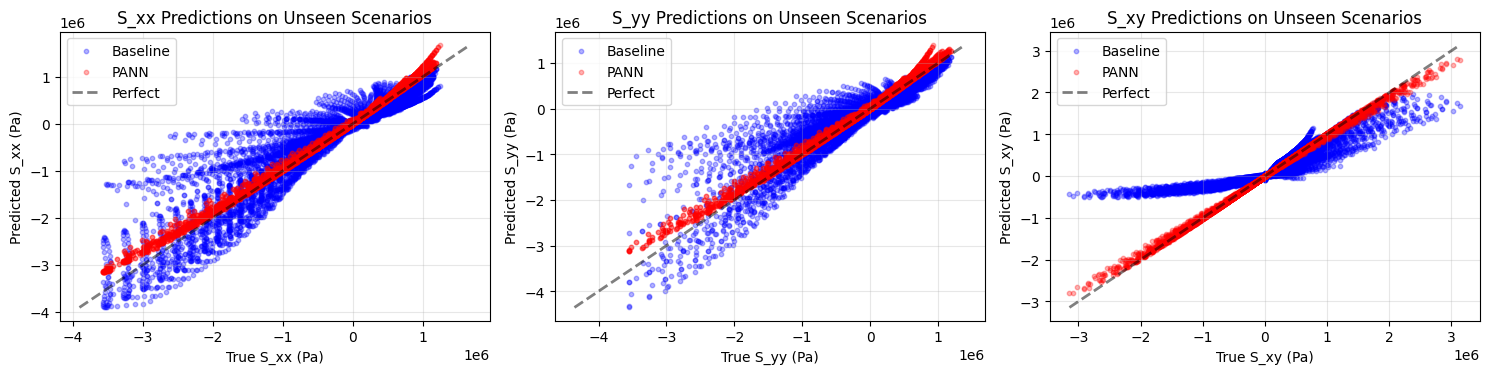

Closer to diagonal = better predictions


In [14]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
component_names = ['S_xx', 'S_yy', 'S_xy']

for i, (ax, comp) in enumerate(zip(axes, component_names)):
    # Plot baseline
    ax.scatter(y_test_unseen[:, i], y_pred_baseline_unseen[:, i], 
               alpha=0.3, s=10, label='Baseline', c='blue')
    
    # Plot PANN
    ax.scatter(y_test_unseen[:, i], y_pred_pann_unseen[:, i], 
               alpha=0.3, s=10, label='PANN', c='red')
    
    # Perfect prediction line
    all_vals = np.concatenate([y_test_unseen[:, i], y_pred_baseline_unseen[:, i], y_pred_pann_unseen[:, i]])
    min_val, max_val = all_vals.min(), all_vals.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.5, label='Perfect')
    
    ax.set_xlabel(f'True {comp} (Pa)')
    ax.set_ylabel(f'Predicted {comp} (Pa)')
    ax.set_title(f'{comp} Predictions on Unseen Scenarios')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Closer to diagonal = better predictions")

## Summary

This notebook provides a **parametric framework** for testing PANN's generalization capabilities:

### Configuration
- Easily modify `training_scenarios` and `test_only_scenarios` at the top
- Current setup: balanced training set excluding sphere and some complex cases

### Key Metrics
1. **Generalization Gap**: Performance drop from seen to unseen scenarios
2. **Absolute R² on Unseen**: Direct performance comparison
3. **Per-Scenario Breakdown**: Identify where each model excels

### Expected Results
PANN should demonstrate:
- Smaller generalization gap (more consistent)
- Better R² on unseen scenarios (especially sphere)
- Physics constraints enabling better extrapolation

### Experimentation
Try different configurations:
- More training scenarios → easier task
- Fewer training scenarios → harder generalization
- Different scenario combinations → test specific hypotheses